In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import torch
import clip
from scripts.clip_wrapper import ClipWrapper
from scripts.plot import visualize_vandt_heatmap
from scripts.methods import vision_heatmap_iba, text_heatmap_iba
from transformers import CLIPProcessor, CLIPModel, CLIPTokenizerFast
from PIL import Image, ImageOps
os.environ["TOKENIZERS_PARALLELISM"] = "false"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
def plot(model, image, text, vbeta=0.1, vvar=1, vlayer=9, tbeta=0.1, tvar=1, tlayer=9, bb=None):
    # Preprocess image
    image = Image.open(image).convert('RGB')
    image_feat = processor(images=image, return_tensors="pt")['pixel_values'].to(device) # 3*224*224
    # Tokenize text
    text_ids = torch.tensor([tokenizer.encode(text, add_special_tokens=True)]).to(device)
    text_words = tokenizer.convert_ids_to_tokens(text_ids[0].tolist())
    # Train information bottleneck on image
    print("Training M2IB on the image...")
    vmap = vision_heatmap_iba(text_ids, image_feat, model, vlayer, vbeta, vvar)
    # Train information bottleneck on text
    print("Training M2IB on the text...")
    tmap = text_heatmap_iba(text_ids, image_feat, model, tlayer, tbeta, tvar)
    image_under = processor(images=image, return_tensors="pt", do_normalize=False)['pixel_values'][0].permute(1,2,0) # no normalization
    if bb:
        scaled_bb = []
        for x, y, w, h in bb:
            hr, vr = image_under.shape[0]/image.size[0], image_under.shape[1]/image.size[1]
            scaled_bb.append((x*hr, y*vr, w*hr, h*vr))
        bb = scaled_bb
    visualize_vandt_heatmap(tmap, vmap, text_words, image_under, bb=bb)

In [3]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
tokenizer = CLIPTokenizerFast.from_pretrained("openai/clip-vit-base-patch32")

# Conceptual Captions

Conceptual Caption provides a large amount of images and their raw descriptions collected from the web. The examples below are from its validation split.

Training M2IB on the image...


Training Bottleneck: 100%|██████████| 10/10 [00:04<00:00,  2.29it/s]


Training M2IB on the text...


Training Bottleneck: 100%|██████████| 10/10 [00:04<00:00,  2.26it/s]


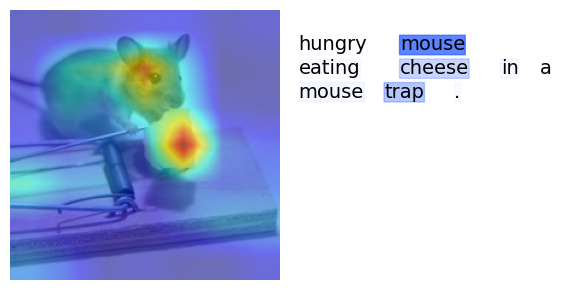

In [4]:
img = "images/mouse.jpg"
text = "hungry mouse eating cheese in a mousetrap."
plot(model, img, text)

Training M2IB on the image...


Training Bottleneck: 100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


Training M2IB on the text...


Training Bottleneck: 100%|██████████| 10/10 [00:04<00:00,  2.13it/s]


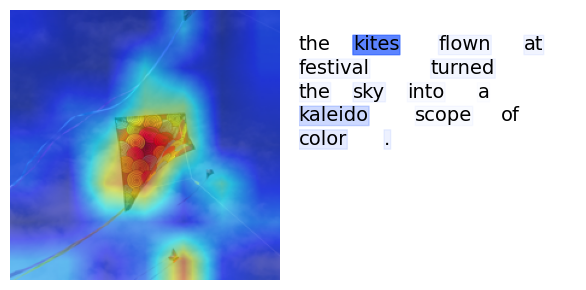

In [5]:
img = "images/kites.jpg"
text = "the kites flown at festival turned the sky into a kaleidoscope of color ."
plot(model, img, text)

Training M2IB on the image...


Training Bottleneck: 100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Training M2IB on the text...


Training Bottleneck: 100%|██████████| 10/10 [00:05<00:00,  2.00it/s]


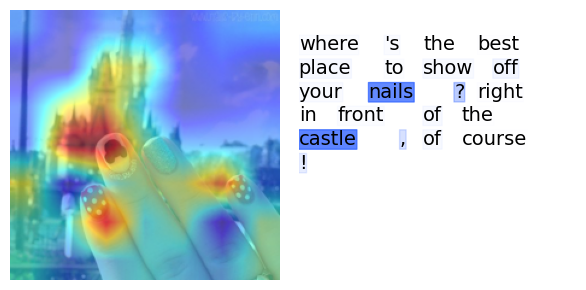

In [6]:
img = "images/castle.jpg"
text = "where 's the best place to show off your nails ? right in front of the castle , of course !"
plot(model, img, text)

# MS-CXR

The MS-CXR dataset is a radiology dataset that provides 1162 image–sentence pairs of bounding boxes and corresponding phrases. Please download the dataset from https://physionet.org/content/ms-cxr/0.1/. We provide two examples below for illustration purpose.
- To be able to run the following code, you need to first download checkpoint finetuned on xray data from https://github.com/rajpurkarlab/CXR-RePaiR.

In [7]:
med_model, _ = clip.load("ViT-B/32", device=device)
med_model.load_state_dict(torch.load("clip-imp-pretrained_128_6_after_4.pt", map_location=device))
med_model = ClipWrapper(med_model)

Training M2IB on the image...


Training Bottleneck: 100%|██████████| 10/10 [00:04<00:00,  2.13it/s]


Training M2IB on the text...


Training Bottleneck: 100%|██████████| 10/10 [00:04<00:00,  2.08it/s]


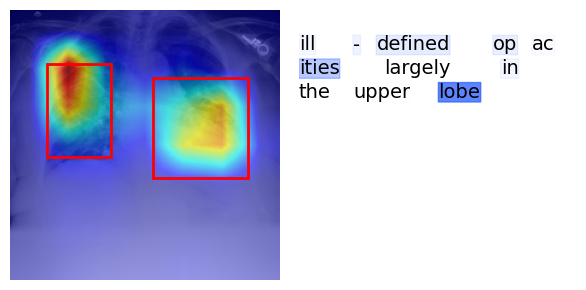

In [8]:
img = "images/cxr_upper.jpg"
text = "ill-defined opacities largely in the upper lobe"
bb = [(347,605,600,1052),(1337,765,899,1127)]
plot(med_model, img, text, vbeta = 1, vvar=1, vlayer=9, tbeta=1, tvar=1, tlayer=7, bb=bb)

Training M2IB on the image...


Training Bottleneck: 100%|██████████| 10/10 [00:04<00:00,  2.30it/s]


Training M2IB on the text...


Training Bottleneck: 100%|██████████| 10/10 [00:04<00:00,  2.27it/s]


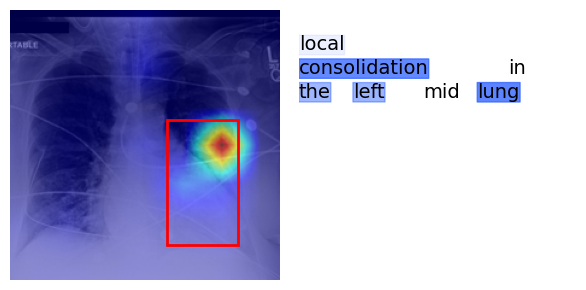

In [9]:
img = "images/cxr_left.jpg"
text = "local consolidation in the left midlung"
bb = [(1767,932,800,1063)]
plot(med_model, img, text, vbeta = 1, vvar=1, vlayer=9, tbeta=1, tvar=1, tlayer=7, bb=bb)